# Forecasting Stock Prices
---
## List of Features

1.  10 day simple moving average (SMA) closing price
2.  50 day simple moving average (SMA) closing price
3.  200 day simple moving average (SMA) closing price
4.  10 day weighted moving average (WMA) closing price
5.  50 day weighted moving average (WMA) closing price
6.  200 day weighted moving average (WMA) closing price
7.  10 day exponential moving average (EMA) closing price
8.  50 day exponential moving average (EMA) closing price
9.  200 day exponential moving average (EMA) closing price
10. Current volume
11. 200 day simple moving average (SMA) volume
12. 14 Day Relative Strength Index (RSI)
13. 20 Day Commodity Channel Index (CCI)
14. Accumulation Distribution (AD)
15. Fast Stochastic K%
16. Slow Stochastic K%
17. Fast Stochastic D%
18. Slow Stochastic D%
19. Moving Average Convergence \ Divergence (MACD)
    
---

<h1>Importing Dependencies</h1>

In [1]:
# Imports

import yfinance as yf
import math
import pandas_datareader.data as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Flatten
from keras import optimizers, callbacks
import tensorflow as tf
import matplotlib.pyplot as plt

import plotly.express as px
plt.style.use('fivethirtyeight')

import talib
talib.set_compatibility(1)

import numpy as np


<h1>Gathering Data</h1>

In [2]:
# Data gathering
yf.pdr_override()
yf_df = web.get_data_yahoo('MSFT', start='2017-01-01', end='2024-01-26')
yf_df

/Users/samfriedman/.local/share/virtualenvs/stocks_lstm_local-oIwf4ot9/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,62.790001,62.840000,62.130001,62.580002,57.138737,20694100
2017-01-04,62.480000,62.750000,62.119999,62.299999,56.883076,21340000
2017-01-05,62.189999,62.660000,62.029999,62.299999,56.883076,24876000
2017-01-06,62.299999,63.150002,62.040001,62.840000,57.376129,19922900
2017-01-09,62.759998,63.080002,62.540001,62.639999,57.193504,20382700
...,...,...,...,...,...,...
2024-01-19,395.760010,398.670013,393.500000,398.670013,398.670013,29272000
2024-01-22,400.019989,400.619995,393.589996,396.510010,396.510010,27016900
2024-01-23,395.750000,399.380005,393.929993,398.899994,398.899994,20525900


In [3]:
# Retrieve matrix dimensions: (# rows, # columns)
yf_df.shape

(1777, 6)

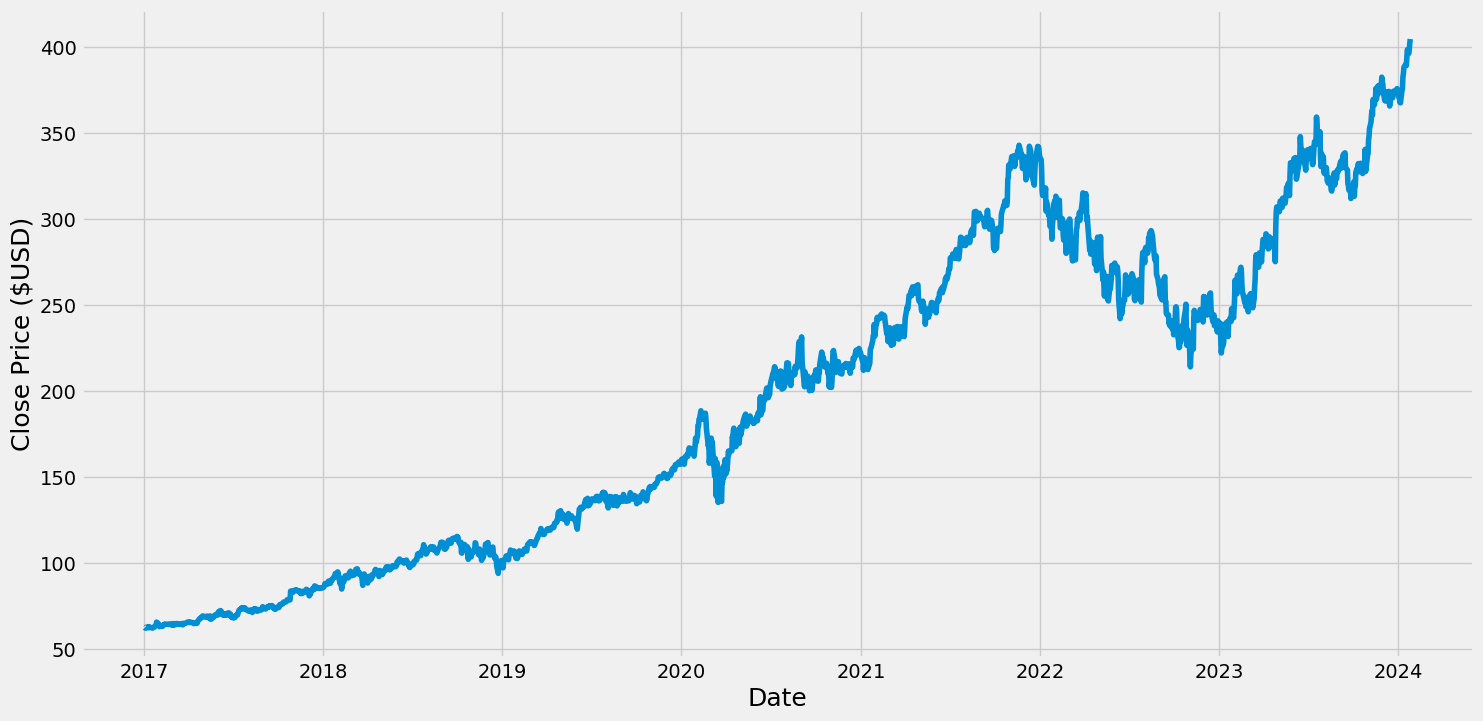

In [4]:
# Visualize closing prices of gathered historic data

plt.figure(figsize=(16,8))
plt.title='Close Price History'
plt.plot(yf_df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($USD)', fontsize=18)

plt.show()

---
# DATA PREPROCESSING

## Technical Indicator Evaluation

In [5]:
# SMA

def moving_SMA(arr, period_length):
    
    output = []
    
    for i in range(period_length, len(arr)):
        current_slice = arr[i-period_length:i]
        current_average = np.average(current_slice)
        output.append(current_average)

    print("Length of moving SMA array is: ", len(output))
    print(output)
    return output

# 10 Day Close SMA
ten_day_SMA_close = moving_SMA(yf_df['Close'].values, 10)

# 50 Day Close SMA
fifty_day_SMA_close = moving_SMA(yf_df['Close'].values, 50)

# 200 Day Close SMA
twohundred_day_SMA_close = moving_SMA(yf_df['Close'].values, 200)

Length of moving SMA array is:  1767
[62.63099975585938, 62.622999572753905, 62.622999572753905, 62.66699981689453, 62.678999710083005, 62.76699981689453, 62.87299995422363, 62.98099975585937, 63.29799957275391, 63.540999221801755, 63.752999496459964, 63.86099967956543, 63.94799957275391, 64.0419994354248, 64.10999946594238, 64.10099945068359, 64.0669994354248, 64.04599952697754, 63.86799964904785, 63.827000045776366, 63.8189998626709, 63.91399955749512, 64.04899940490722, 64.14299964904785, 64.22799949645996, 64.32099952697754, 64.44899978637696, 64.50500030517578, 64.52800064086914, 64.45400047302246, 64.49100074768066, 64.43900108337402, 64.41200141906738, 64.37700080871582, 64.36800117492676, 64.43100090026856, 64.4420009613037, 64.47300071716309, 64.521000289917, 64.56400070190429, 64.54500045776368, 64.60800018310547, 64.67000045776368, 64.7360008239746, 64.71700057983398, 64.72100067138672, 64.73500061035156, 64.74000091552735, 64.77900085449218, 64.86700057983398, 64.9390007019

In [6]:
# WMA

# 10 Day Close WMA
ten_day_WMA_close = talib.WMA(yf_df['Close'].values, 10)
print(ten_day_WMA_close[9:])

# 50 Day Close WMA
fifty_day_WMA_close = talib.WMA(yf_df['Close'].values, 50)
print(fifty_day_WMA_close[49:])

# 200 Day Close WMA
twohundred_day_WMA_close = talib.WMA(yf_df['Close'].values, 200)
print(twohundred_day_WMA_close[199:])



[ 62.6758178   62.65199966  62.59327233 ... 393.4783647  395.77381869
 398.00254517]
[ 64.24349833  64.27456497  64.31303567 ... 379.07603262 380.10927167
 381.20025965]
[ 71.44759053  71.53254277  71.61973235 ... 350.63576207 351.27987896
 351.9414605 ]


In [7]:
# EMA

# 10 Day Close EMA
ten_day_EMA_close = talib.EMA(yf_df['Close'].values, 10)
print(ten_day_WMA_close[9:])

# 50 Day Close EMA
fifty_day_EMA_close = talib.EMA(yf_df['Close'].values, 50)
print(fifty_day_WMA_close[49:])

# 200 Day Close EMA
twohundred_day_EMA_close = talib.EMA(yf_df['Close'].values, 200)
print(twohundred_day_WMA_close[199:])



[ 62.6758178   62.65199966  62.59327233 ... 393.4783647  395.77381869
 398.00254517]
[ 64.24349833  64.27456497  64.31303567 ... 379.07603262 380.10927167
 381.20025965]
[ 71.44759053  71.53254277  71.61973235 ... 350.63576207 351.27987896
 351.9414605 ]


In [8]:
# Current Volume
volume = yf_df['Volume'].values

In [9]:
# 200 Day Volume SMA 

twohundred_day_SMA_volume = moving_SMA(yf_df['Volume'].values, 200)


Length of moving SMA array is:  1577
[22357517.5, 22320550.5, 22289314.5, 22279266.5, 22282788.0, 22268460.5, 22277549.5, 22330566.5, 22581059.0, 22642731.0, 22674844.0, 22688030.5, 22715736.5, 22652836.5, 22636653.0, 22602987.0, 22574794.5, 22462913.5, 22335812.5, 22248540.0, 22216194.0, 22114752.0, 21990431.0, 21949317.0, 21931910.0, 21936711.5, 21948995.0, 21872901.0, 21873373.5, 21868403.0, 21889766.5, 21970013.5, 22014942.5, 22104173.0, 22131655.0, 22166002.0, 22180559.0, 22194020.5, 22228952.5, 22232374.0, 22208000.0, 22181832.0, 22360836.0, 22378503.5, 22403522.5, 22414342.5, 22405062.0, 22378100.0, 22327056.0, 22329045.0, 22257847.5, 22248063.0, 22114383.5, 22171700.0, 22148057.5, 22161693.0, 22175912.0, 22160248.0, 22160435.5, 22149078.0, 22202343.5, 22309728.0, 22332632.5, 22351426.5, 22470814.5, 22481579.5, 22508126.0, 22603971.0, 22646123.5, 22698027.0, 22770334.0, 22874027.0, 23034362.0, 23194723.5, 23299098.5, 23442758.5, 23620138.5, 23676826.5, 23803756.5, 23990298.0, 23

In [10]:
# 14 Day RSI
rsis = talib.RSI(yf_df['Close'].values, 14)

print(len(rsis))
print(rsis[13:])

1777
[55.68857488 62.05124794 63.65693392 ... 73.40117907 75.7885282
 77.18063269]


In [11]:
# 20 Day CCI

ccis = talib.CCI(high=yf_df['High'].values, 
                              low=yf_df['Low'].values, 
                              close=yf_df['Close'].values, 
                              timeperiod=20)

print(len(ccis))
print(ccis[19:])

1777
[131.18494478  55.13422662 -13.11851698 ... 124.71526419 141.05690141
 133.59640903]


In [12]:
# A/D

def accumulation_distribution(highs, lows, closes, volumes):
    volumes = np.array(list(map(lambda x: float(x), volumes)))
    ad = talib.AD(high=highs, low=lows, close=closes, volume=volumes)
    output = ad
    print(output)
    return output

ads = accumulation_distribution(highs=yf_df['High'].values, 
                              lows=yf_df['Low'].values, 
                              closes=yf_df['Close'].values, 
                              volumes=yf_df['Volume'].values)

[ 5.53793605e+06 -3.60777824e+06 -7.16149253e+06 ...  3.45409966e+09
  3.44949099e+09  3.45042935e+09]


In [13]:
# Fast Stochastic K and D

fast_stochastic_ks, fast_stochastic_ds = talib.STOCHF(high=yf_df['High'].values, 
                              low=yf_df['Low'].values, 
                              close=yf_df['Close'].values)

In [14]:
# Slow Stochastic K and D

slow_stochastic_ks, slow_stochastic_ds = talib.STOCH(high=yf_df['High'].values, 
                              low=yf_df['Low'].values, 
                              close=yf_df['Close'].values)


In [15]:
# MACD

macds, macdsignals, macdhist  = talib.MACDFIX(yf_df['Close'].values)
print(len(macds))
print(macds[33:])

1777
[0.35970621 0.34086263 0.34171232 ... 6.70581079 7.23814941 7.74852128]


In [16]:
# Compile all results to compare to https://www.tradingview.com/symbols/NASDAQ-MSFT/technicals/

---

## Formatting Input DF

In [17]:

# Add technical indicators as dataframe columns

df = pd.DataFrame()

df['fifty_day_SMA_close'] = fifty_day_SMA_close[150:]
df['twohundred_day_SMA_close'] = twohundred_day_SMA_close
df['ten_day_WMA_close'] = ten_day_WMA_close[200:]
df['fifty_day_WMA_close'] = fifty_day_WMA_close[200:]
df['twohundred_day_WMA_close'] = twohundred_day_WMA_close[200:]
df['ten_day_EMA_close'] = ten_day_EMA_close[200:]
df['fifty_day_EMA_close'] = fifty_day_EMA_close[200:]
df['twohundred_day_EMA_close'] = twohundred_day_EMA_close[200:]
df['twohundred_day_SMA_volume'] = twohundred_day_SMA_volume
df['rsis'] = rsis[200:]
df['ccis'] = ccis[200:]
df['ads'] = ads[200:]
df['fast_stochastic_ks'] = fast_stochastic_ks[200:]
df['fast_stochastic_ds'] = fast_stochastic_ds[200:]
df['slow_stochastic_ks'] = slow_stochastic_ks[200:]
df['slow_stochastic_ds'] = slow_stochastic_ds[200:]
df['macds'] = macds[200:]
df['Close'] = yf_df['Close'][200:].values
df['Volume'] = yf_df['Volume'][200:].values

yf_df['Close']

Date
2017-01-03     62.580002
2017-01-04     62.299999
2017-01-05     62.299999
2017-01-06     62.840000
2017-01-09     62.639999
                 ...    
2024-01-19    398.670013
2024-01-22    396.510010
2024-01-23    398.899994
2024-01-24    402.559998
2024-01-25    404.869995
Name: Close, Length: 1777, dtype: float64

In [18]:
yf_df = yf_df[200:]

assert(yf_df.shape[0] == df.shape[0])

In [19]:
# Isolate dates as independent variables. This may be redundant later but useful in attaching dates to final predictions.
date_strings = yf_df.index.strftime("%Y-%m-%d").tolist()
dates = [pd.to_datetime(d) for d in date_strings]

df['Date'] = dates

df.set_index('Date', inplace=True, drop=True)

# Convert dataframe to a numpy array
dataset = df['Close'].values

# Compute row count to train the model on => 80% of data for training
training_data_len = math.ceil(len(dataset) * 0.8)
print(training_data_len)

1262


In [20]:
# Specific scaler for each col. If negative values can exist, -1 to 1. Else 0 to 1
# Negative: CCI, MACD

scalers = {}

scaled_df = df.copy()

for col in df:
    
    column = df[col].values.reshape(-1,1)
    scaler_name = col+'_scaler'
    
    if df[col].min() >= 0:
        scalers[scaler_name] = MinMaxScaler(feature_range=(0,1))
        scaled_df[col] = scalers[scaler_name].fit_transform(np.float32(column))
    elif df[col].min() < 0:
        scalers[scaler_name] = MinMaxScaler(feature_range=(-1,1))
        scaled_df[col] = scalers[scaler_name].fit_transform(np.float32(column))
    else:
        print('We have a major poo poo on aisle 21!')
        
assert(scaled_df.shape[1] == df.shape[1])

scaled_df

unscaled_df = scalers['Close_scaler'].inverse_transform(scaled_df['Close'].values.reshape(-1,1))

unscaled_df


        

array([[ 77.61   ],
       [ 77.91   ],
       [ 78.81   ],
       ...,
       [398.9    ],
       [402.55997],
       [404.87   ]], dtype=float32)

In [21]:
scaled_df_train = scaled_df[:training_data_len]
scaled_df_train.shape[1]

19

In [22]:
x_train = []
y_train = []

scaled_close_prices = scaled_df_train['Close']

batch_size = 60


for i in range(batch_size, len(scaled_df_train)):
    x_train.append(scaled_df_train[i-batch_size:i])      # All features at positions 0 to 59
    y_train.append(scaled_df_train['Close'].iloc[i])        # Close at position 60
  
# Convert x_train and y_train to numpy arrays
Lstm_x, Lstm_y = np.array(x_train), np.array(y_train)

In [23]:
# Reshape the x_train data set => Add third column
# Lstm_x = np.reshape(Lstm_x, (Lstm_x.shape[0], Lstm_x.shape[1], 1))
Lstm_x.shape, Lstm_y.shape

((1202, 60, 19), (1202,))

<h1>Define the Models</h1>

In [24]:
# Build the LSTM Model(s)
print('y.shape[0]: ', Lstm_y.shape[0])
print('x.shape[1]: ', Lstm_x.shape[1])
print('x.shape[2]: ', Lstm_x.shape[2])

x, y = Lstm_x, Lstm_y

old_model = Sequential()
old_model.add(LSTM(64, return_sequences=True,
              input_shape=(x.shape[1], x.shape[2])))
old_model.add(LSTM(64, return_sequences=False))
old_model.add(Dense(32))
old_model.add(Dense(1))
old_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
old_model.fit(x, y, epochs=16, batch_size=1)
old_model.summary()



random_example_model = Sequential()
random_example_model.add(LSTM(64, input_shape=(x.shape[1], x.shape[2]), return_sequences=True, recurrent_dropout=0))
random_example_model.add(LSTM(64, return_sequences=False, recurrent_dropout=0))
random_example_model.add(Dense(1, activation='relu'))
random_example_model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae'])
random_example_model.fit(x, y, batch_size=1, epochs=4)
random_example_model.summary()


Lstm_model1 = Sequential()
Lstm_model1.add(LSTM(units=64, return_sequences=True,
                input_shape=(x.shape[1], x.shape[2])))
Lstm_model1.add(Dropout(0.2))
Lstm_model1.add(LSTM(units=50, return_sequences=True))
Lstm_model1.add(Dropout(0.2))
Lstm_model1.add(LSTM(units=50, return_sequences=True))
Lstm_model1.add(Dropout(0.2))
Lstm_model1.add(LSTM(units=50))
Lstm_model1.add(Dropout(0.2))
Lstm_model1.add(Dense(units=1))
Lstm_model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
es = callbacks.EarlyStopping(
    monitor='loss', patience=15, restore_best_weights=True)
Lstm_model1.fit(x, y, epochs=16, validation_split=0.1,
                batch_size=1, verbose=1, callbacks=[es])
Lstm_model1.summary()



y.shape[0]:  1202
x.shape[1]:  60
x.shape[2]:  19
Epoch 1/16
1202/1202 [==============================] - 12s 9ms/step - loss: 0.0022 - mae: 0.0324
Epoch 2/16
1202/1202 [==============================] - 11s 9ms/step - loss: 7.8724e-04 - mae: 0.0214
Epoch 3/16
1202/1202 [==============================] - 11s 9ms/step - loss: 7.2541e-04 - mae: 0.0204
Epoch 4/16
1202/1202 [==============================] - 11s 9ms/step - loss: 5.9318e-04 - mae: 0.0180
Epoch 5/16
1202/1202 [==============================] - 11s 9ms/step - loss: 5.4356e-04 - mae: 0.0175
Epoch 6/16
1202/1202 [==============================] - 11s 9ms/step - loss: 5.2685e-04 - mae: 0.0170
Epoch 7/16
1202/1202 [==============================] - 11s 9ms/step - loss: 4.5194e-04 - mae: 0.0161
Epoch 8/16
1202/1202 [==============================] - 11s 9ms/step - loss: 4.1585e-04 - mae: 0.0157
Epoch 9/16
1202/1202 [==============================] - 11s 9ms/step - loss: 4.2924e-04 - mae: 0.0153
Epoch 10/16
1202/1202 [=============

<h1>Predicting</h1>

In [25]:

# Create the testing data set

# Array containing scaled values from index 1543 to 2003
test_data = scaled_df[training_data_len - 60:]

dataset = df['Close'].values

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i])

x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(
    x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [29]:
# Retrieve models' predicted price values
old_model_predictions = old_model.predict(x_test)
print(old_model_predictions.shape)

random_example_model_predictions = random_example_model.predict(x_test)
print(random_example_model_predictions.shape)


model1_predictions = Lstm_model1.predict(x_test)
print(model1_predictions.shape)

10/10 [==============================] - 0s 7ms/step
(315, 1)
10/10 [==============================] - 0s 7ms/step
(315, 1)
10/10 [==============================] - 0s 12ms/step
(315, 1)


In [30]:
norm_scaler = scalers['Close_scaler']

# Unscale predictions to compare to original closing prices (y_test)
old_model_predictions = norm_scaler.inverse_transform(
    old_model_predictions)

# Unscale predictions to compare to original closing prices (y_test)
random_example_model_predictions = norm_scaler.inverse_transform(
    random_example_model_predictions)

# Unscale predictions to compare to original closing prices (y_test)
model1_predictions = norm_scaler.inverse_transform(model1_predictions)

In [31]:
# Evaluate root mean square error (RMSE) => Standard deviation of the residuals

old_model_rmse = np.sqrt(np.mean(old_model_predictions - y_test)**2)
random_example_model_rmse = np.sqrt(np.mean(random_example_model_predictions - y_test)**2)
model1_rmse = np.sqrt(np.mean(model1_predictions - y_test)**2)

print(old_model_rmse,
      random_example_model_rmse,
      model1_rmse)

4.160068620954241 229.09358719114275 9.688674103267608


<h1>Results</h1>

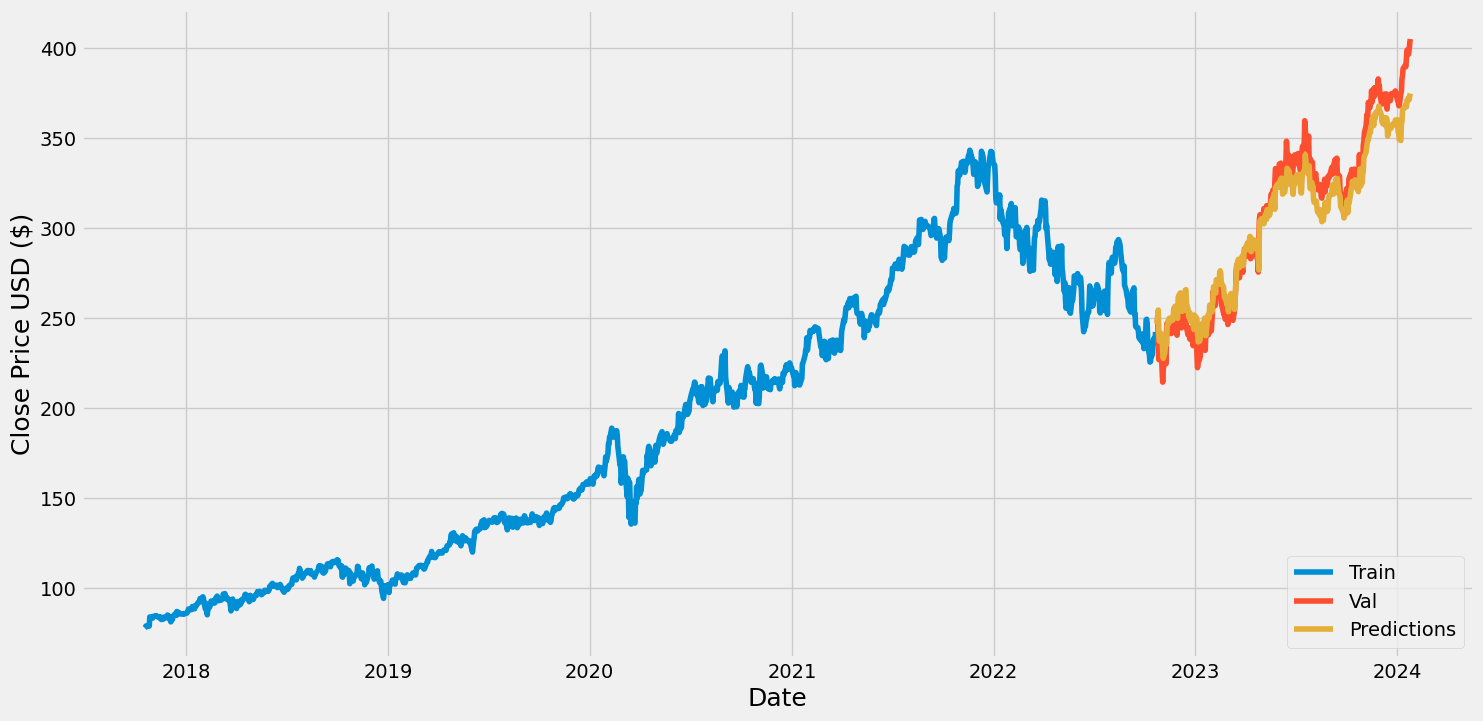

In [32]:
# Plot the data
data = df.filter(['Close'])
train = data[:training_data_len].copy()
valid = data[training_data_len:].copy()

valid['Predictions'] = old_model_predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title='Old Model'
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

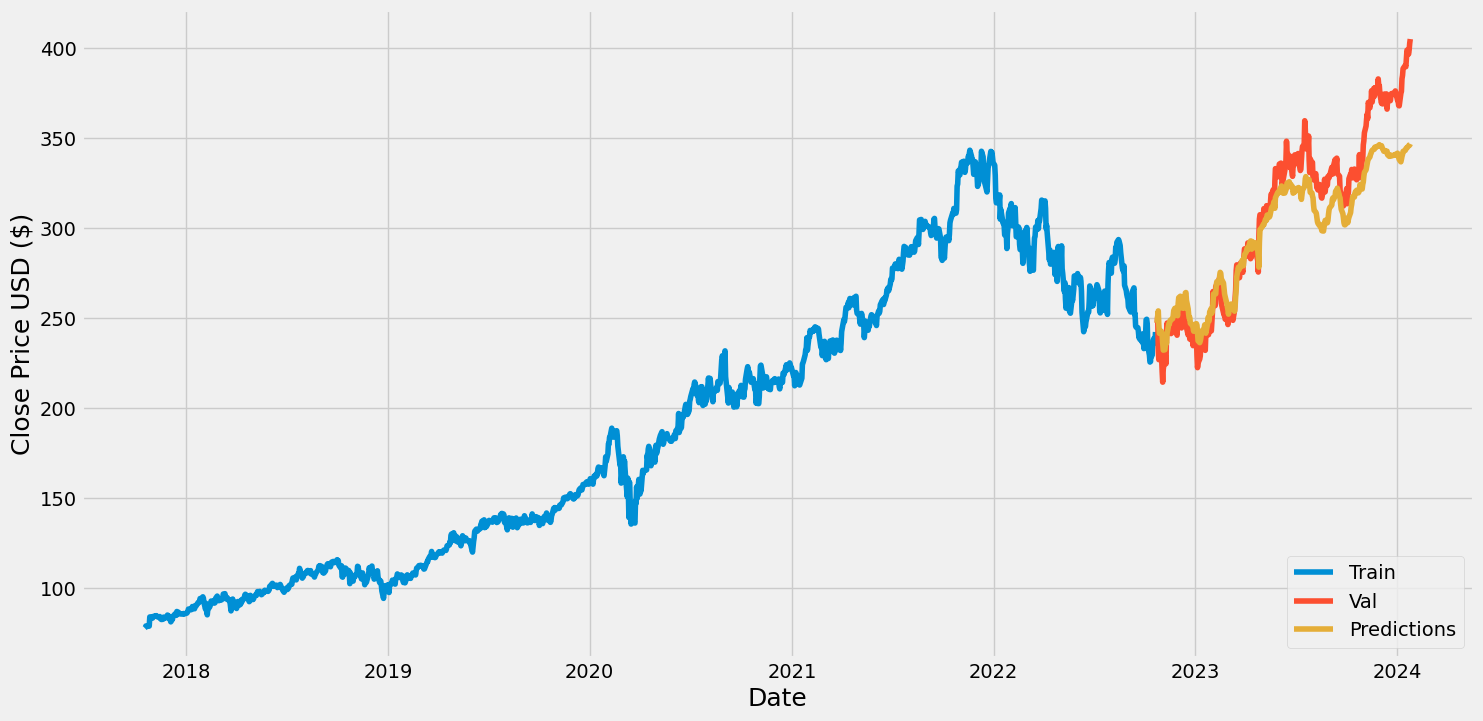

In [35]:
# Plot the data
data1 = df.filter(['Close'])
train1 = data1[:training_data_len].copy()
valid1 = data1[training_data_len:].copy()

valid1['Predictions'] = model1_predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title='Other Model'
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train1['Close'])
plt.plot(valid1[['Close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<h1>Further Analysis</h1>

In [37]:
# Check model's efficacy at predicting if stock price is higher or lower than previous day
total_days = valid.shape[0]

preds = valid['Predictions'].values
actual_opens = valid['Close'].values

good = 0
bad = 0

for i in range(1, total_days-1):
    actual_dif = preds[i] - preds[i-1]
    predicted_dif = actual_opens[i] - actual_opens[i-1]
    and_signs = (actual_dif > 0 and predicted_dif > 0) or (actual_dif < 0 and predicted_dif < 0)
    
    if and_signs:
        good += 1
    else:
        bad +=1
        
print('good: ', good)
print('bad: ', bad)
    

good:  161
bad:  152


In [38]:
# Check model1's efficacy at predicting if stock price is higher or lower than previous day
total_days = valid1.shape[0]

preds1 = valid1['Predictions'].values
actual_opens1 = valid1['Close'].values

good1 = 0
bad1 = 0

for i in range(1, total_days-1):
    actual_dif = preds1[i] - preds1[i-1]
    predicted_dif = actual_opens1[i] - actual_opens1[i-1]
    and_signs = (actual_dif > 0 and predicted_dif > 0) or (actual_dif < 0 and predicted_dif < 0)
    
    if and_signs:
        good1 += 1
    else:
        bad1 +=1
        
print('good: ', good1)
print('bad: ', bad1)
    

good:  157
bad:  156
